In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import numpy as np 

dfa = pd.read_csv('data/NatalBR_Apartments.csv', encoding = "ISO-8859-1")
dfa.drop('Unnamed: 0', axis=1, inplace = True)

dfh = pd.read_csv('data/NatalBR_Housing.csv', encoding = "ISO-8859-1")
dfh.drop('Unnamed: 0', axis=1, inplace = True)

In [87]:
#Supress scientific notation
pd.options.display.float_format = '{:.4f}'.format
dfa['adv_sale'].describe()

count        6308.0000
mean       708334.7237
std       7878523.5907
min         39000.0000
25%        250000.0000
50%        410000.0000
75%        677247.7500
max     600000000.0000
Name: adv_sale, dtype: float64

In [88]:
#Drop outliers that will interfere with the plotting
dfa.drop(dfa[dfa['adv_sale'].astype(float)>10000000].index, inplace=True)
dfa.drop(dfa[dfa['adv_size'] > 9000].index, inplace=True)

dfa['adv_sale'].describe()

count      6301.0000
mean     572170.3598
std      604805.9220
min       39000.0000
25%      249999.0000
50%      410000.0000
75%      675000.0000
max     6000000.0000
Name: adv_sale, dtype: float64

In [58]:
print("Before: {}".format(dfa.shape))
dfa.drop_duplicates(inplace = True)
print("After: {}" .format(dfa.shape))

Before: (6301, 50)
After: (5100, 50)


<h3>Exploring 'adv_sale' and its relationships with other variables

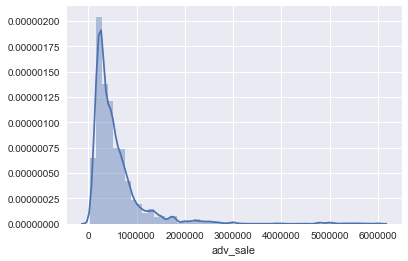

In [89]:
#Exploring adv_sale
sns.distplot(dfa['adv_sale'])

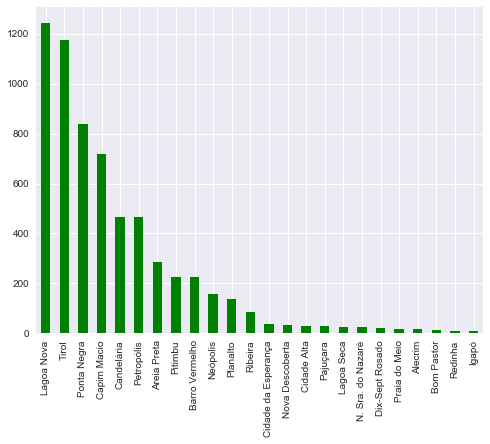

In [90]:
#Number of apartments by district
f, ax = plt.subplots(figsize=(8, 6))
dfa['district'].value_counts().plot(kind='bar', color='green')

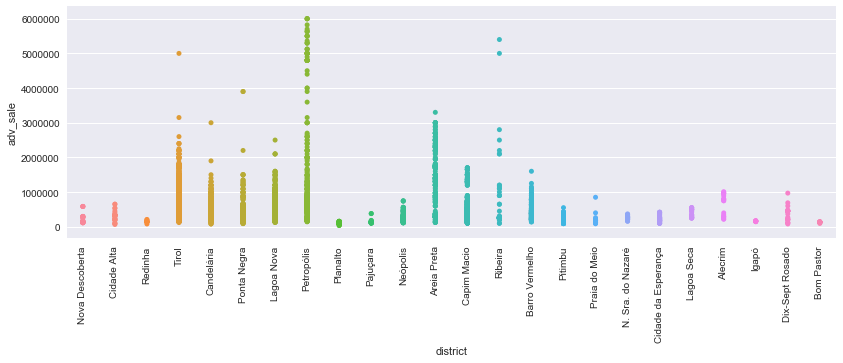

In [91]:
#District houses with respect to sale price
g = sns.factorplot(x='district', y='adv_sale', data=dfa, kind='strip', aspect=3, )
g.set_xticklabels(rotation=90)

In [92]:
# Calculating the correlation between each feature and SalePrice
corr = dfa.corr()
print(corr['adv_sale'].sort_values(ascending=False)[:])

adv_sale                    1.0000
adv_size                    0.7809
adv_park                    0.6319
adv_bath                    0.5534
adv_bed                     0.5443
density_hospital            0.4016
density_restaurant          0.3249
density_pharma              0.2675
density_school              0.2432
am_hospital                 0.1843
density_clinic              0.1656
density_fast_food           0.1650
leisure                     0.1646
pool                        0.1644
elevator                    0.1610
balcony                     0.1487
bbq                         0.1306
density_tourism             0.1247
density_leisure             0.1160
density_shop_supermarket    0.1048
density_worship             0.0457
am_clinic                   0.0129
district_num               -0.0117
density_shop_mall          -0.0142
am_restaurant              -0.0372
am_pharma                  -0.0475
am_school                  -0.0482
am_shop_mall               -0.0875
density_police      

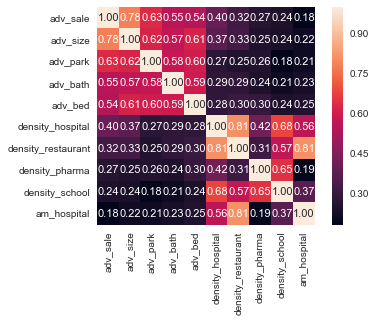

In [93]:
cols = corr.nlargest(10, 'adv_sale')['adv_sale'].index
cm = np.corrcoef(dfa[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<h3>Outliers

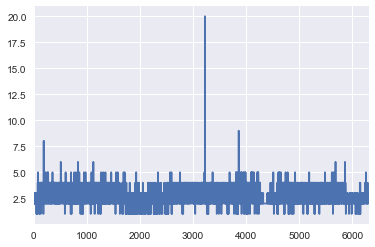

In [94]:
dfa['adv_bed'].plot()

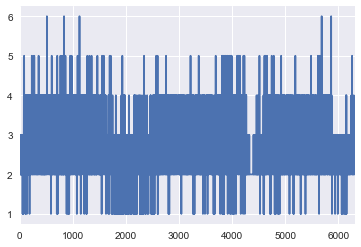

In [95]:
dfa.drop(dfa[dfa['adv_bed'] > 7].index, inplace=True)
dfa['adv_bed'].plot()

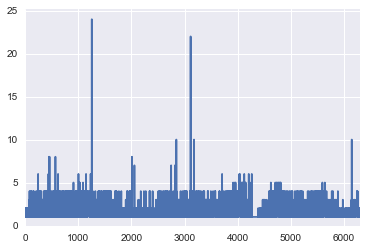

In [96]:
dfa['adv_park'].plot()

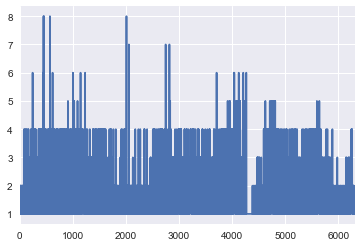

In [97]:
dfa.drop(dfa[dfa['adv_park'] > 8].index, inplace=True)
dfa['adv_park'].plot()

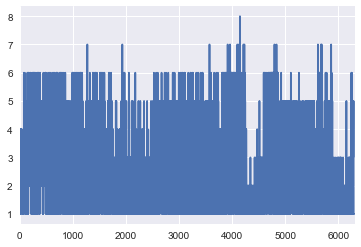

In [98]:
dfa['adv_bath'].plot()

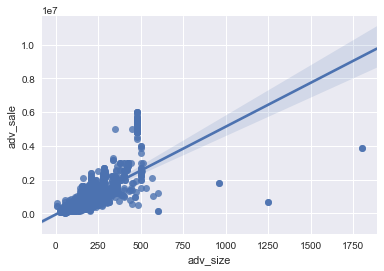

In [99]:
sns.regplot(x='adv_size', y='adv_sale', data=dfa)

In [100]:
dfa['adv_size'].quantile(0.95)

282.0

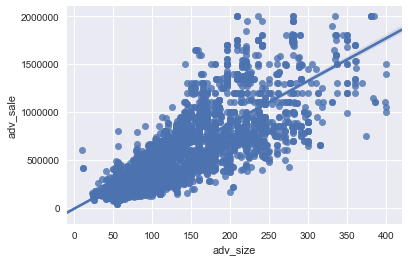

In [101]:
dfa.drop(dfa[dfa['adv_size'].astype(float)>400].index, inplace=True)
dfa.drop(dfa[dfa['adv_sale'].astype(float)>2000000].index, inplace=True)

sns.regplot(x='adv_size', y='adv_sale', data=dfa)

<h3>Skewdness

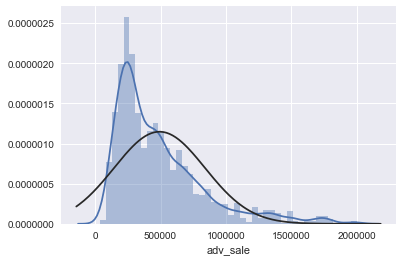

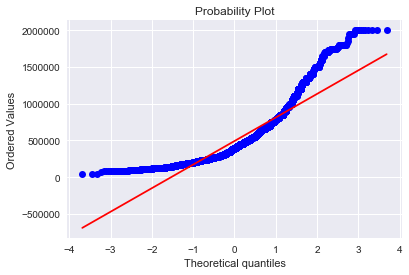

In [102]:
sns.distplot(dfa['adv_sale'], fit=norm);
fig = plt.figure()
res = stats.probplot(dfa['adv_sale'], plot=plt)

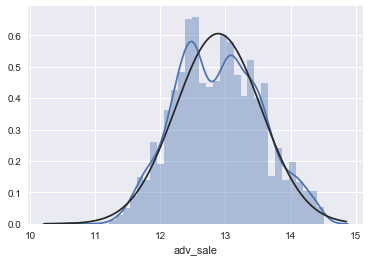

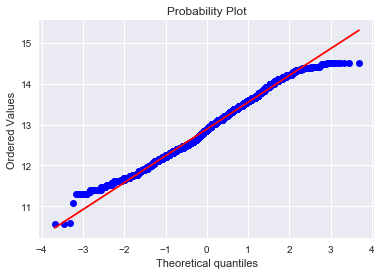

In [103]:
#log sale to reduce skewness
dfa['adv_sale'] = np.log(dfa['adv_sale'])
sns.distplot(dfa['adv_sale'], fit=norm);
fig = plt.figure()
res = stats.probplot(dfa['adv_sale'], plot=plt)

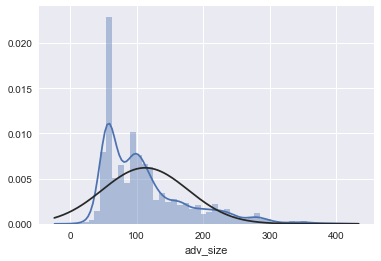

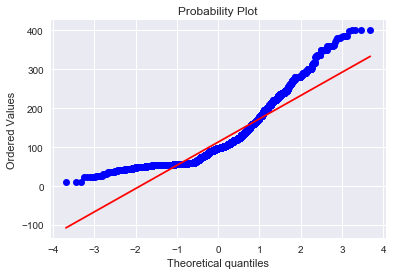

In [104]:
#Check for skewness on size
sns.distplot(dfa['adv_size'], fit=norm);
fig = plt.figure()
res = stats.probplot(dfa['adv_size'], plot=plt)

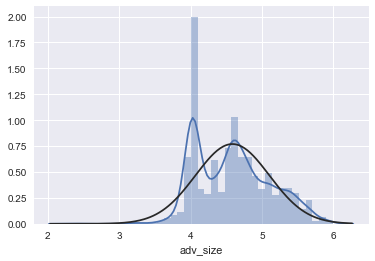

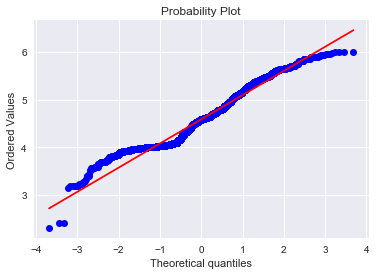

In [105]:
#Reduce skewness
dfa['adv_size'] = np.log(dfa['adv_size'])
sns.distplot(dfa['adv_size'], fit=norm);
fig = plt.figure()
res = stats.probplot(dfa['adv_size'], plot=plt)

<h3>Modelling

In [106]:
#Drop non-numerical data
dfa.drop(['re_type', 'district','district_num','region'], axis=1, inplace=True)

In [107]:
#Create df without target variable
dfa_notarget = dfa.drop(['adv_sale'], axis = 1)

Training the model

In [108]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold, learning_curve
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
 
X = dfa[dfa_notarget.columns].values
y = dfa[dfa.columns[9]].values

cv_r2, cv_mse = [], []
for train, test in RepeatedKFold(n_splits=10, n_repeats=1).split(X):
    model = GradientBoostingRegressor().fit(X[train],y[train])
    X_pred = model.predict(X[test])
    
    cv_r2.append(r2_score(y[test],X_pred))
    cv_mse.append(mean_squared_error(y[test],X_pred))

print(np.mean(cv_r2), np.sqrt(np.mean(cv_mse)))

0.856686077144 0.249229242783


Feature Importance

In [109]:
df = pd.DataFrame(model.feature_importances_, index=dfa_notarget.columns, columns=['fi']).reset_index()
#df.sort_values('fi',ascending=False)

In [83]:
# unimportant = df.drop(df[df['fi'].astype(float) > 0.010].index)
# unimportant['index'].values
# dfa.drop(unimportant['index'].values, axis = 1, inplace = True )

array(['am_worship', 'area_worship', 'am_pharma', 'area_pharma',
       'density_pharma', 'area_tourism', 'density_tourism', 'am_leisure',
       'area_leisure', 'am_clinic', 'area_clinic', 'density_clinic',
       'am_fast_food', 'area_fast_food', 'density_fast_food', 'am_police',
       'area_police', 'area_restaurant', 'am_shop_mall', 'area_shop_mall',
       'density_shop_mall', 'am_shop_supermarket', 'area_shop_supermarket',
       'density_shop_supermarket', 'am_school', 'area_school',
       'density_school', 'area_hospital', 'density_hospital'], dtype=object)

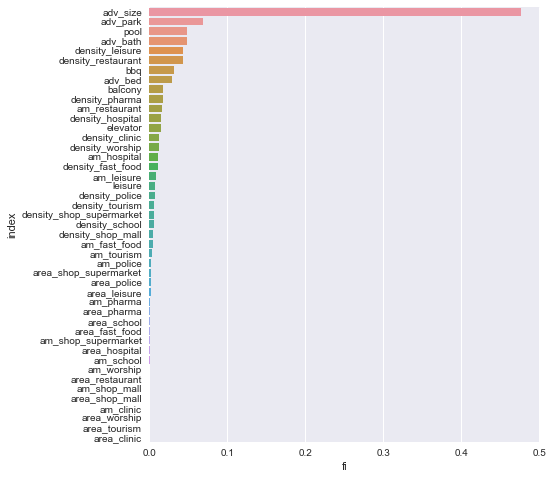

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(7,8))
df = pd.DataFrame(model.feature_importances_, index=dfa_notarget.columns, columns=['fi']).reset_index()
df.sort_values('fi',ascending=False)
sns.barplot(x='fi', y='index', data=df.sort_values('fi',ascending=False), ax = ax)

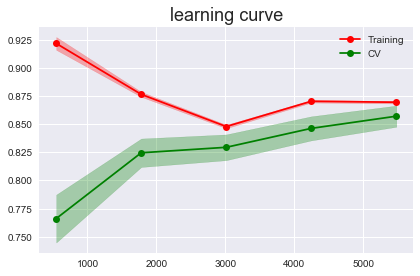

In [111]:
train_sizes, train_scores, test_scores = learning_curve(
        model, X, y.ravel(), scoring='r2', n_jobs=2,
        cv=RepeatedKFold(n_splits=10, n_repeats=1),
        train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.3, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="CV")
plt.legend(loc="best")
plt.title('learning curve', fontsize=18)
plt.tight_layout()
plt.show()